# TPC-C Multi-Tenant with Distributed PVC and Tuned MySQL 8.4

* data is generated and loaded into databases in a distributed filesystem
* experiments do not use preloaded data

* MySQL uses no improved args

In [1]:
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from bexhoma import collectors

%matplotlib inline

# Functions for Nice Plots

In [2]:
def sanitize_filename(title, max_length=100):
    # Replace non-alphanumeric characters with underscores
    safe = re.sub(r'[^a-zA-Z0-9-_]+', '_', title.strip())
    # Truncate to a safe length
    return safe[:max_length].rstrip('_')
    
def plot_bars(df, y, title, estimator):
    df_plot = df.copy()
    #df_plot = df_plot[df_plot['client']=='1']
    df_plot = df_plot.sort_values(['num_tenants','type'])
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x='num_tenants',
        y=y,
        hue='type',
        estimator=estimator,
        palette='Set2',
        hue_order=hue_order
    )
    show_height = False
    if show_height:
        for bar in ax.patches:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # X: center of bar
                    height,                             # Y: top of bar
                    f'{height:.1f}',                    # Text (1 decimal place)
                    ha='center', va='bottom', fontsize=8
                )
    # Get tick positions (i.e., the x-axis categories)
    xticks = ax.get_xticks()
    bar_width = ax.patches[0].get_width()
    # Create a mapping from (num_tenants, type) to hatch
    grouped = df_plot.groupby(['num_tenants', 'type']).agg({y: estimator}).reset_index()
    #print(grouped)
    grouped_dict = {(row['num_tenants'], row['type']): hatch_map[row['type']] for _, row in grouped.iterrows()}
    bars = sorted(ax.patches, key=lambda bar: bar.get_x() if bar.get_height() > 0 else 10000)
    for bar, (_, row) in zip(bars, grouped.iterrows()):
        bar.my_id = (row['num_tenants'], row['type'])  # or anything else like an index or uuid
        bar.set_hatch(hatch_map[row['type']]) #grouped_dict[(bar.my_id)])
        bar.set_edgecolor('black')
        bar.set_linewidth(1)
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
    # Final touches
    plt.legend(title='Type')
    ax.legend(fontsize=18)
    #ax.legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))  # move outside
    plt.title(f"{title}", fontsize=24)
    #plt.title(f"{title} by Number of Tenants and Type", fontsize=24)
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    # Remove y-axis label
    ax.set_ylabel('')  # or ax.set(ylabel='')
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

def plot_boxplots(df, y, title):
    plt.figure(figsize=(10, 6))
    # Hatch styles for each type
    hatch_map = {
        'container': '/',
        'database': '\\',
        'schema': 'x'
    }
    hue_order = ['container', 'database', 'schema']
    
    # Plot boxplots grouped by num_tenants and colored by type
    ax = sns.boxplot(
        data=df,
        x='num_tenants',
        y=y,#'Goodput (requests/second)',
        hue='type',
        palette='Set2'  # consistent colors per type
    )
    # Add vertical separator lines between groups
    # Get the number of unique num_tenants and type
    num_groups = df['num_tenants'].nunique()
    num_types = df['type'].nunique()
    
    # Extract hue order
    hue_order = ax.get_legend_handles_labels()[1]
    num_hue = len(hue_order)
    
    # Get hue order from seaborn (types)
    _, type_order = ax.get_legend_handles_labels()
    num_types = len(type_order)
    
    #print(len(ax.patches))
    # Set hatches correctly: patches are grouped by x then by hue
    for i, patch in enumerate(ax.patches):
        #print(i)
        type_index = i // (num_groups)
        if type_index >= num_types:
            break
        type_name = type_order[type_index]
        patch.set_hatch(hatch_map.get(type_name, ''))
        #print(hatch_map.get(type_name, ''))
        patch.set_edgecolor('black')
        patch.set_linewidth(1)
    
    # Each num_tenants group has num_types boxes
    for i in range(1, num_groups):
        xpos = i - 0.5 #0.5
        ax.axvline(x=xpos, color='gray', linestyle='--', alpha=0.5)
    
    
    # Update legend with matching hatches
    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        hatch = hatch_map.get(label, '')
        handle.set_hatch(hatch)
        handle.set_edgecolor('black')
        handle.set_linewidth(1)
    
    #title = "Goodput [req/s] Distribution per Tenant"
    plt.title(title, fontsize=24)
    plt.xlabel("Number of Tenants")
    plt.ylabel("")#"Goodput (requests/second)")
    plt.xlabel("Number of Tenants", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    plt.legend(title="Type")
    ax.legend(fontsize=18)
    plt.tight_layout()
    filename = "tpcc_" + filename_prefix + sanitize_filename(title) + ".png"    
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Collect Results

In [3]:
path = r"C:\data\benchmarks"
#path = r"/home/perdelt/benchmarks"
filename_prefix = "mysql_"

In [4]:
codes = [
    # with loading:
    #"1753719849","1753726333","1753732596","1753738775","1753863203","1753746505","1753755793","1753764407","1753772991","1753782376"
    # without loading:
    "1753885555","1753888904","1753892425","1753896006","1753900727","1753883878","1753887176","1753890691","1753907029","1753898188"
]

len(codes)

10

In [5]:
collect = collectors.benchbase(path, codes)

In [6]:
df_performance = collect.get_monitoring_single_all("stream")
df_performance

,CPU [CPUs],CPU Throttled,Max CPU,Max RAM [Gb],Max RAM Cached [Gb],Locks,Access Exclusive,Access Share,Exclusive,Row Exclusive,...,Sync Time,Write Time,Cache Hit Ratio [%],Number Autoanalyze,Number Autovacuum,Variance of Core Util [%],client,type,num_tenants,code
MySQL-1-1-65536-0-1,1601.43,0.0,3.14,5.21,10.10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.65,1,container,1,1753885555
MySQL-1-1-65536-0-2,1804.21,0.0,3.99,5.47,11.72,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.75,2,container,1,1753885555
MySQL-1-1-65536-1,2028.99,0.0,6.28,5.25,10.43,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.83,1,database,1,1753883878
MySQL-1-1-65536-2,1689.83,0.0,4.69,5.47,11.66,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.88,2,database,1,1753883878
MySQL-1-1-65536-0-1,1045.15,0.0,2.28,5.12,9.70,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.87,1,container,2,1753888904
MySQL-1-1-65536-0-2,1140.13,0.0,3.44,5.33,10.59,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.84,2,container,2,1753888904
MySQL-1-1-65536-1-1,982.68,0.0,4.80,5.09,9.62,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.86,1,container,2,1753888904
MySQL-1-1-65536-1-2,942.15,0.0,2.79,5.28,10.36,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.84,2,container,2,1753888904
MySQL-1-1-65536-1,3258.27,0.0,8.28,6.43,12.48,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.52,1,database,2,1753887176
MySQL-1-1-65536-2,2731.34,0.0,11.89,6.81,14.55,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.19,2,database,2,1753887176


<Axes: title={'center': 'core_variance'}>

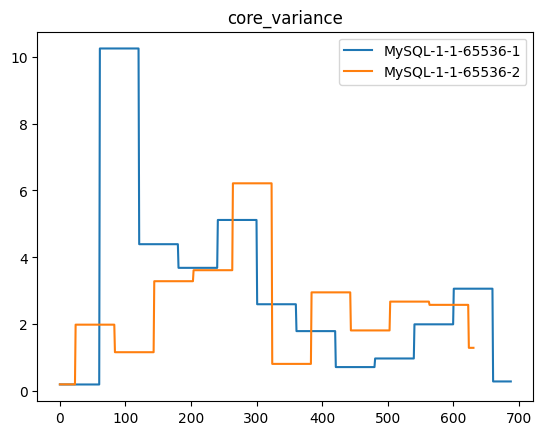

In [7]:
metric="core_variance"
code = codes[9]
df_monitoring = collect.get_monitoring_timeseries_single(code, metric=metric)

df_monitoring.plot(title=metric)
#df_monitoring

# Monitoring Aggregated Values

In [8]:
df_performance = collect.get_monitoring_all("stream")

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance#[['Max CPU', 'client', 'type', 'num_tenants']]

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Locks,Access Exclusive,Access Share,Exclusive,...,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],type,num_tenants,code
0,1,1601.43,5.21,10.10,3.14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.65,container,1,1753885555
1,2,1804.21,5.47,11.72,3.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.75,container,1,1753885555
0,1,2028.99,5.25,10.43,6.28,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.83,database,1,1753883878
1,2,1689.83,5.47,11.66,4.69,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.88,database,1,1753883878
0,1,2027.83,10.21,19.32,7.08,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.87,container,2,1753888904
1,2,2082.28,10.61,20.95,6.23,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.84,container,2,1753888904
0,1,3258.27,6.43,12.48,8.28,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1.52,database,2,1753887176
1,2,2731.34,6.81,14.55,11.89,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1.19,database,2,1753887176
0,1,3787.28,15.40,29.63,10.24,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1.81,container,3,1753892425
1,2,3994.13,16.07,32.30,11.13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,2.04,container,3,1753892425


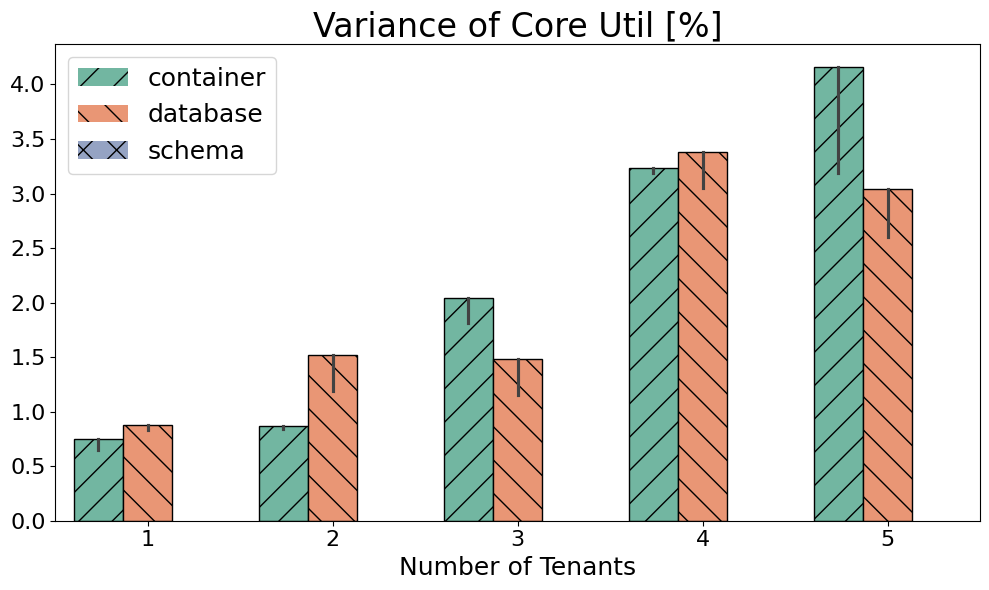

In [9]:
plot_bars(df_performance, y='Variance of Core Util [%]', title='Variance of Core Util [%]', estimator='max')

# Performance Results per Tenant

In [38]:
df_performance = collect.get_performance_all_single()

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance = df_performance.dropna()
df_performance

,connection,configuration,experiment_run,client,pod,pod_count,bench,profile,target,time,...,Latency Distribution.Median Latency (microseconds),Latency Distribution.Minimum Latency (microseconds),Latency Distribution.25th Percentile Latency (microseconds),Latency Distribution.90th Percentile Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),Latency Distribution.75th Percentile Latency (microseconds),Latency Distribution.Average Latency (microseconds),type,num_tenants,code
connection_pod,,,,,,,,,,,,,,,,,,,,,
MySQL-1-1-65536-0-1-1,MySQL-1-1-65536-0-1,MySQL-1-1-65536-0,1,1,m7kbf.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,24025,1053,14940,93636,4333843,38930,267615,container,1,1753885555
MySQL-1-1-65536-0-2-1,MySQL-1-1-65536-0-2,MySQL-1-1-65536-0,1,2,rdz4s.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,22093,1068,13968,82193,3987259,33363,252857,container,1,1753885555
MySQL-1-1-65536-1-1,MySQL-1-1-65536-1,MySQL-1-1-65536,1,1,br7md.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,23573,1334,14213,105952,4228802,40616,234512,database,1,1753883878
MySQL-1-1-65536-2-1,MySQL-1-1-65536-2,MySQL-1-1-65536,1,2,56jj8.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,22250,1134,13897,81949,3921908,34960,245936,database,1,1753883878
MySQL-1-1-65536-0-1-1,MySQL-1-1-65536-0-1,MySQL-1-1-65536-0,1,1,szs4d.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,25802,1305,15362,168573,7790977,51241,437870,container,2,1753888904
MySQL-1-1-65536-1-1-1,MySQL-1-1-65536-1-1,MySQL-1-1-65536-1,1,1,rbld2.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,26550,1211,15022,186078,6004709,58620,467062,container,2,1753888904
MySQL-1-1-65536-0-2-1,MySQL-1-1-65536-0-2,MySQL-1-1-65536-0,1,2,nhgbl.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,22612,1109,13588,90577,6276140,37272,417585,container,2,1753888904
MySQL-1-1-65536-1-2-1,MySQL-1-1-65536-1-2,MySQL-1-1-65536-1,1,2,6rgv4.dbmsbenchmarker,1,tpcc,mysql,65536,600,...,22745,1175,13530,122386,6385374,38963,480231,container,2,1753888904
MySQL-1-1-65536-1-1,MySQL-1-1-65536-1,MySQL-1-1-65536,1,1,5znqj.dbmsbenchmarker,2,tpcc,mysql,65536,600,...,23645,1158,14025,98384,4945902,40331,274452,database,2,1753887176


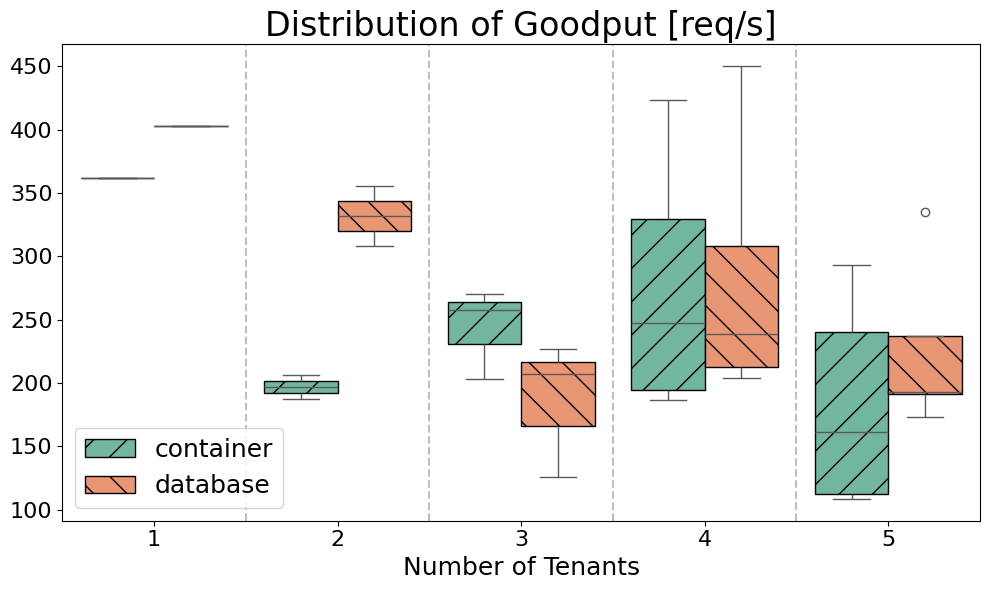

In [39]:
plot_boxplots(df_performance_first, y='Goodput (requests/second)', title='Distribution of Goodput [req/s]')

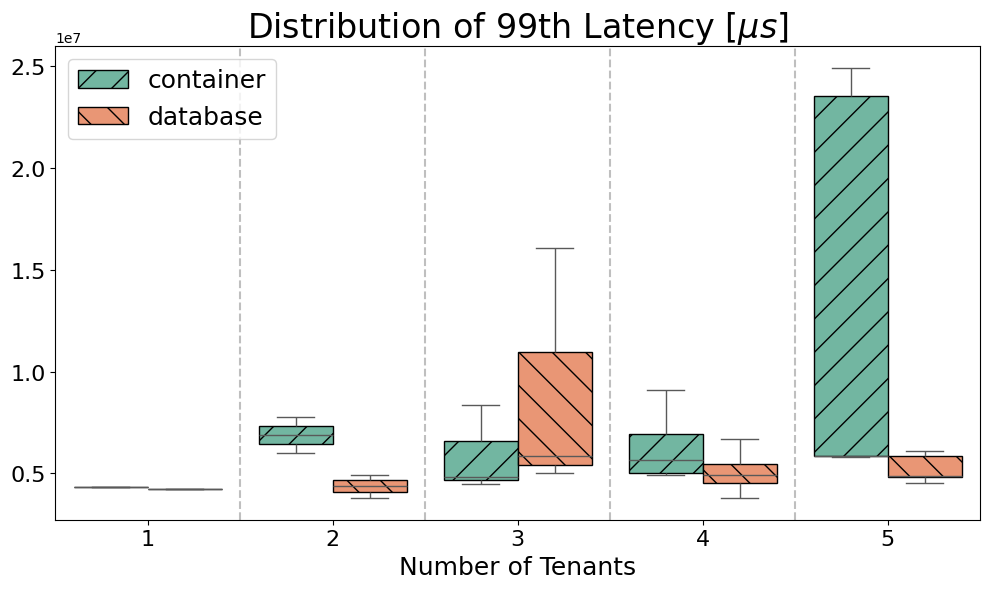

In [40]:
plot_boxplots(df_performance_first, y='Latency Distribution.99th Percentile Latency (microseconds)', title='Distribution of 99th Latency [$\mu s$]')

# Performance Results per Total

In [13]:
df_performance = collect.get_performance_all()
df_performance = df_performance.dropna()
df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance.dropna(inplace=True)

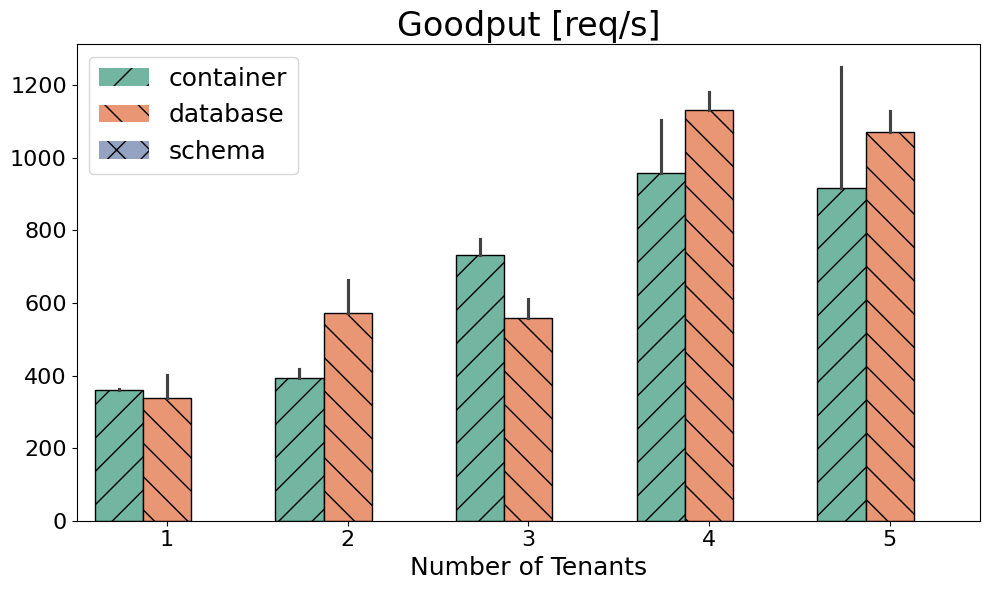

In [14]:
plot_bars(df_performance, y='Goodput (requests/second)', title='Goodput [req/s]', estimator='min')

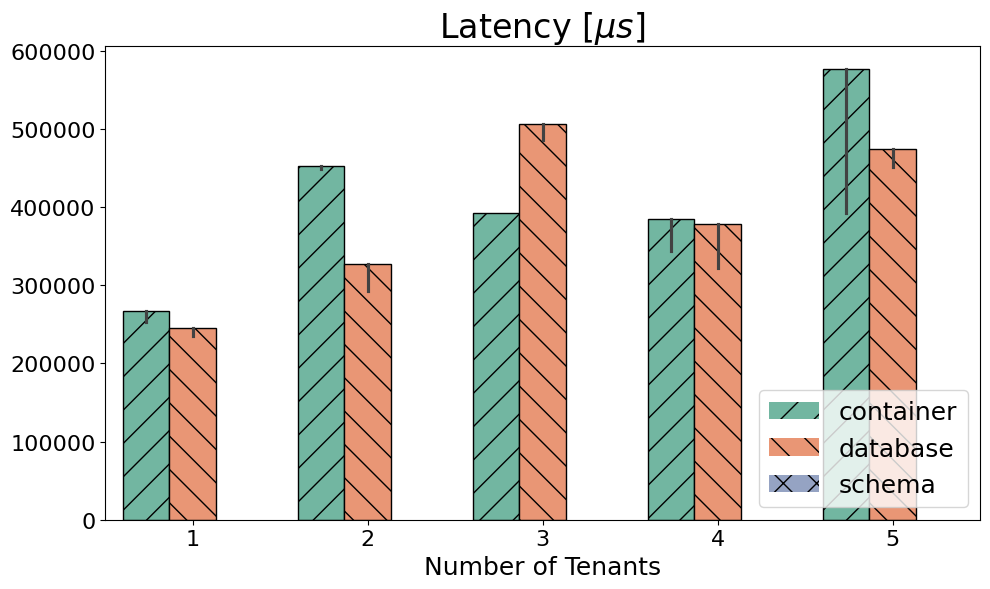

In [15]:
plot_bars(df_performance, y='Latency Distribution.Average Latency (microseconds)', title='Latency [$\mu s$]', estimator='max')

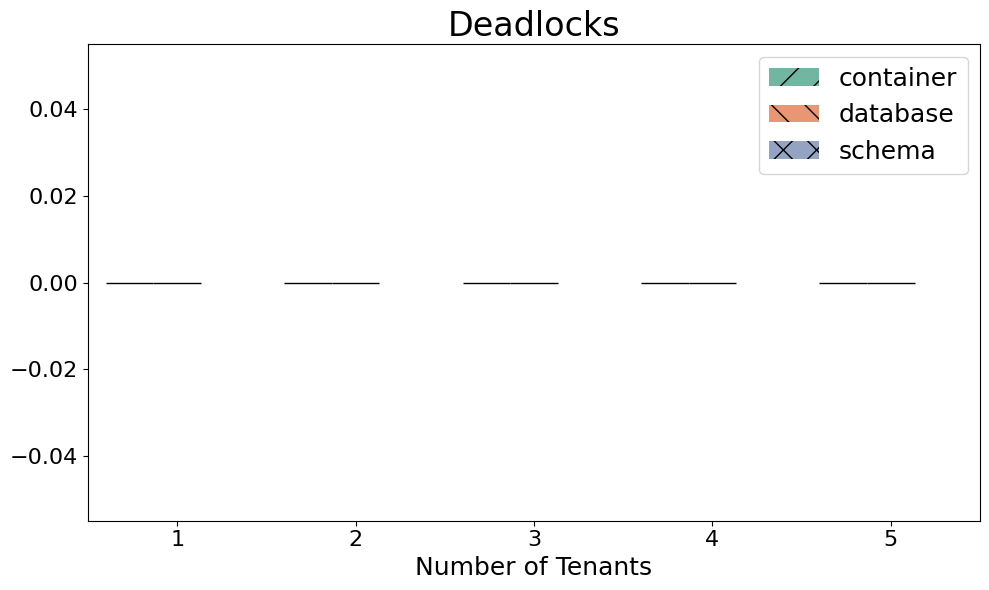

In [16]:
plot_bars(df_performance, y='num_errors', title='Deadlocks', estimator='max')

In [17]:
df_performance = collect.get_loading_time_max_all()

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance

,time_load,time_ingest,time_check,terminals,pods,tenant,client,datadisk,type,num_tenants,code
MySQL-1-1-65536-0-1,9079.0,4524.0,4540.0,1,1,0,1,7256,container,1,1753885555
MySQL-1-1-65536-0-2,9079.0,4524.0,4540.0,1,1,0,2,8532,container,1,1753885555
MySQL-1-1-65536-1,9750.0,4856.0,4879.0,1,1,,1,7172,database,1,1753883878
MySQL-1-1-65536-2,9750.0,4856.0,4879.0,1,1,,2,8584,database,1,1753883878
MySQL-1-1-65536-0-1,9978.0,4665.0,5298.0,1,1,0,1,6808,container,2,1753888904
MySQL-1-1-65536-0-2,9978.0,4665.0,5298.0,1,1,0,2,7538,container,2,1753888904
MySQL-1-1-65536-1-1,10596.0,5284.0,5297.0,1,1,1,1,6666,container,2,1753888904
MySQL-1-1-65536-1-2,10596.0,5284.0,5297.0,1,1,1,2,7332,container,2,1753888904
MySQL-1-1-65536-1,9098.0,4520.0,4547.0,1,2,,1,9780,database,2,1753887176
MySQL-1-1-65536-2,9098.0,4520.0,4547.0,1,2,,2,12113,database,2,1753887176


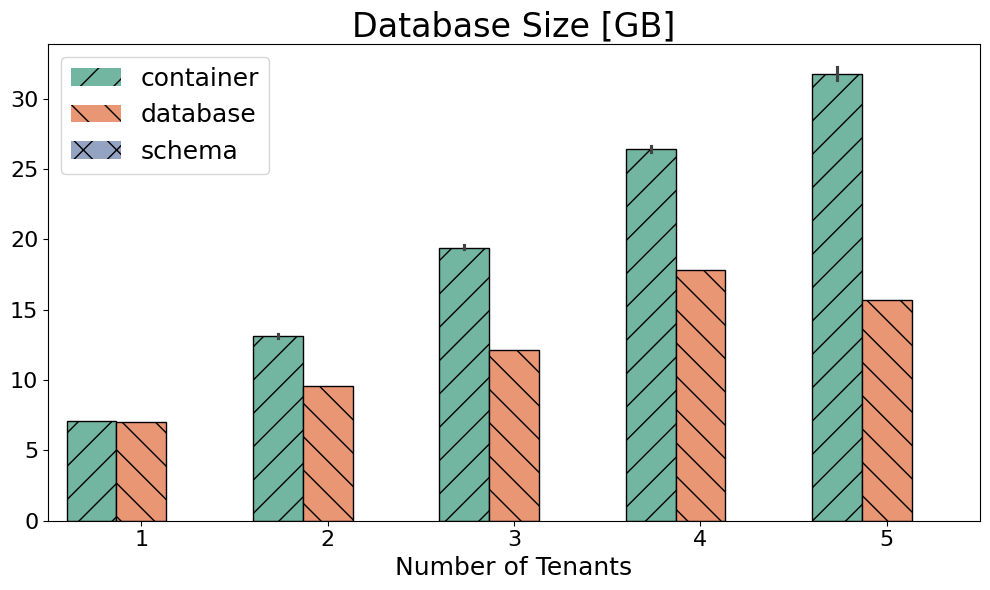

In [18]:
#df_performance_first = df_performance[df_performance['client'] == '1']
# Divide datadisk by the count of rows with the same type and num_tenants
df = df_performance_first.copy()
# Create a mask for rows where type is not "container"
mask = df['type'] != 'container'

# Only apply the group count to the relevant rows
group_counts = df[mask].groupby(['type', 'num_tenants'])['datadisk'].transform('count')

# Initialize the column with NaN (or 0, if preferred)
df['datadisk_normalized'] = df['datadisk'] / 1024

# Apply the normalized value only where the mask is True
df.loc[mask, 'datadisk_normalized'] = df.loc[mask, 'datadisk'] / group_counts / 1024

plot_bars(df, y='datadisk_normalized', title='Database Size [GB]', estimator='sum')

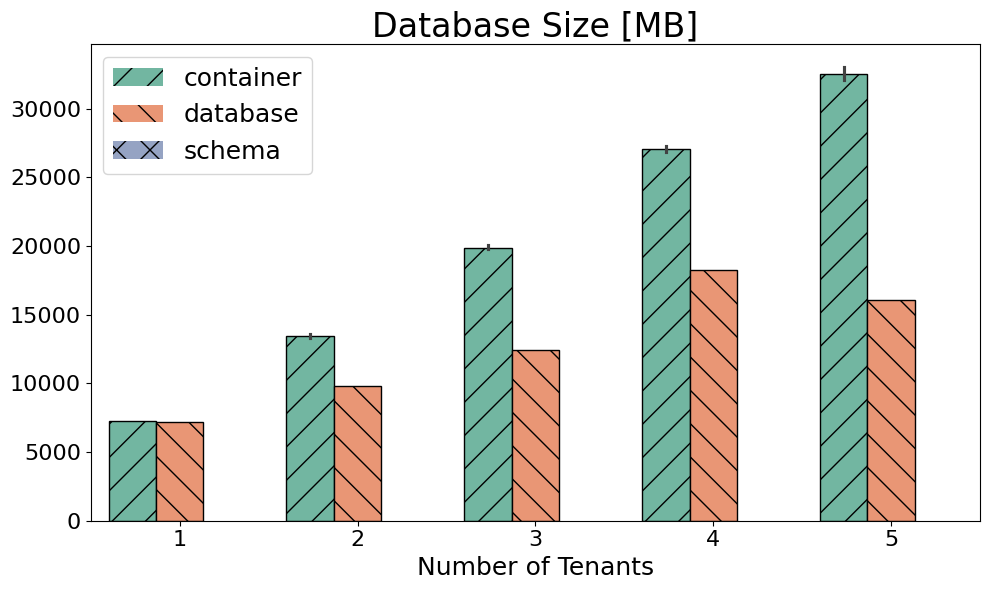

In [19]:
plot_bars(df_performance_first, y='datadisk', title='Database Size [MB]', estimator='sum')

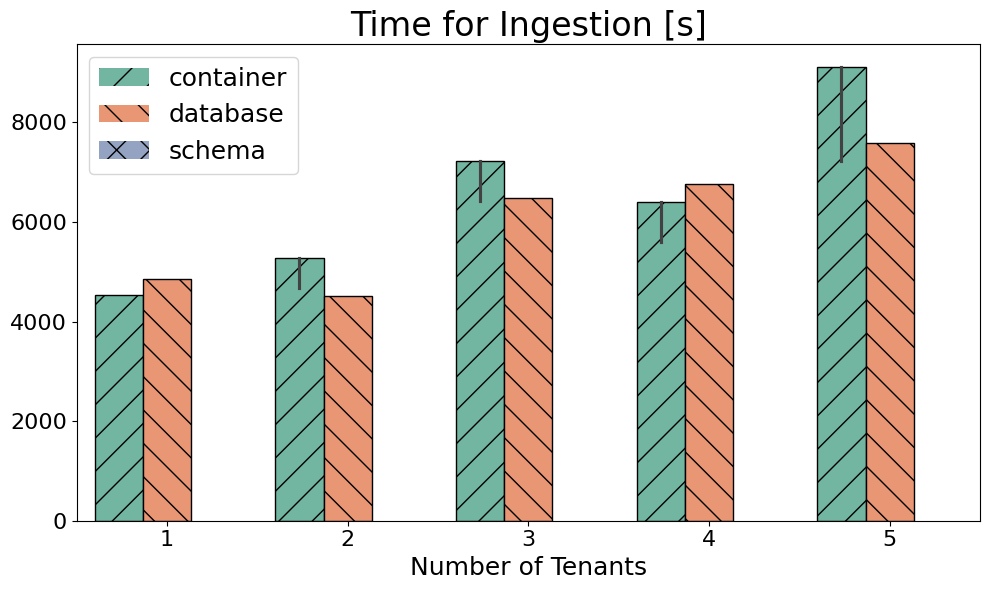

In [20]:
plot_bars(df_performance_first, y='time_ingest', title='Time for Ingestion [s]', estimator='max')

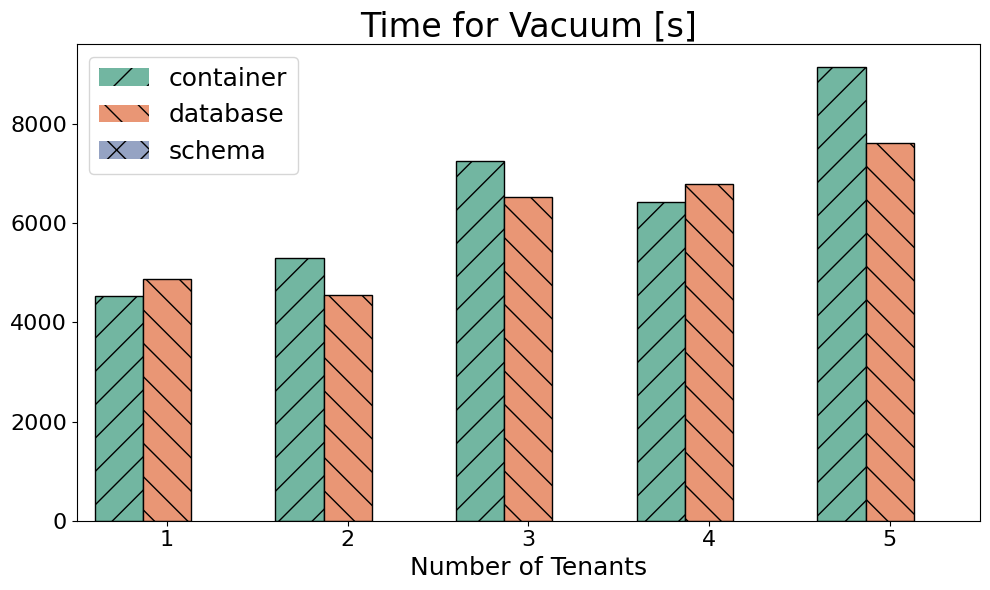

In [21]:
plot_bars(df_performance_first, y='time_check', title='Time for Vacuum [s]', estimator='max')

# Hardware Monitoring for Benchmarking Phase

In [22]:
df_performance = collect.get_monitoring_all(type="stream")

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance

,client,CPU [CPUs],Max RAM [Gb],Max RAM Cached [Gb],Max CPU,CPU Throttled,Locks,Access Exclusive,Access Share,Exclusive,...,Heap Hits,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],type,num_tenants,code
0,1,1601.43,5.21,10.10,3.14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.65,container,1,1753885555
1,2,1804.21,5.47,11.72,3.99,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.75,container,1,1753885555
0,1,2028.99,5.25,10.43,6.28,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.83,database,1,1753883878
1,2,1689.83,5.47,11.66,4.69,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.88,database,1,1753883878
0,1,2027.83,10.21,19.32,7.08,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.87,container,2,1753888904
1,2,2082.28,10.61,20.95,6.23,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.84,container,2,1753888904
0,1,3258.27,6.43,12.48,8.28,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1.52,database,2,1753887176
1,2,2731.34,6.81,14.55,11.89,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1.19,database,2,1753887176
0,1,3787.28,15.40,29.63,10.24,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1.81,container,3,1753892425
1,2,3994.13,16.07,32.30,11.13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,2.04,container,3,1753892425


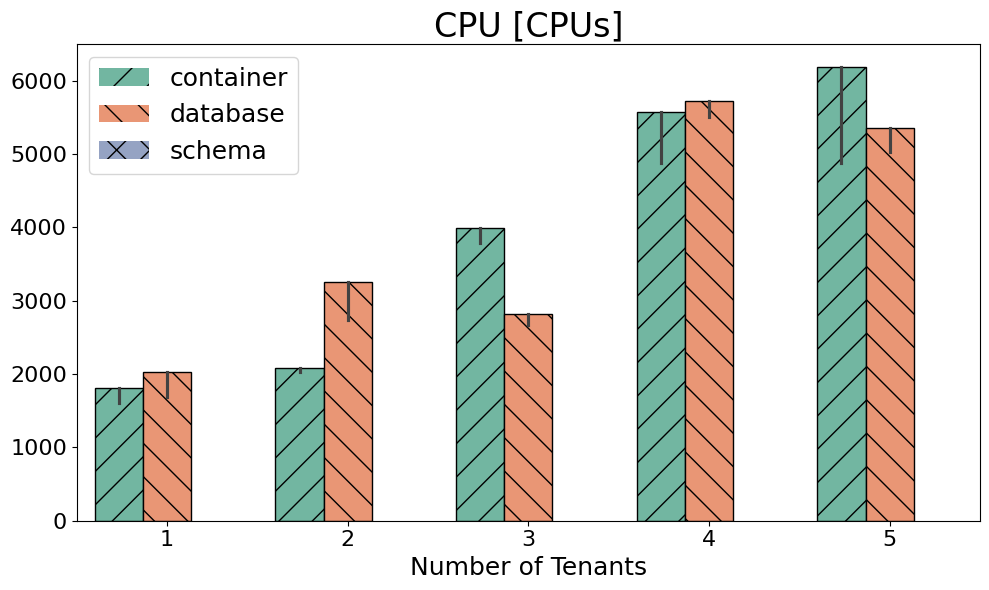

In [23]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

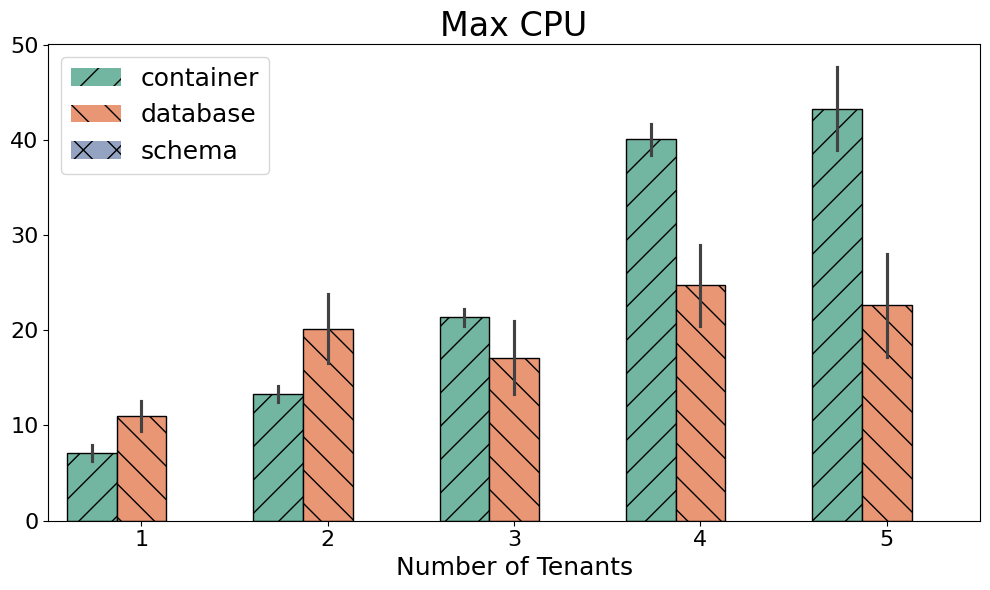

In [24]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

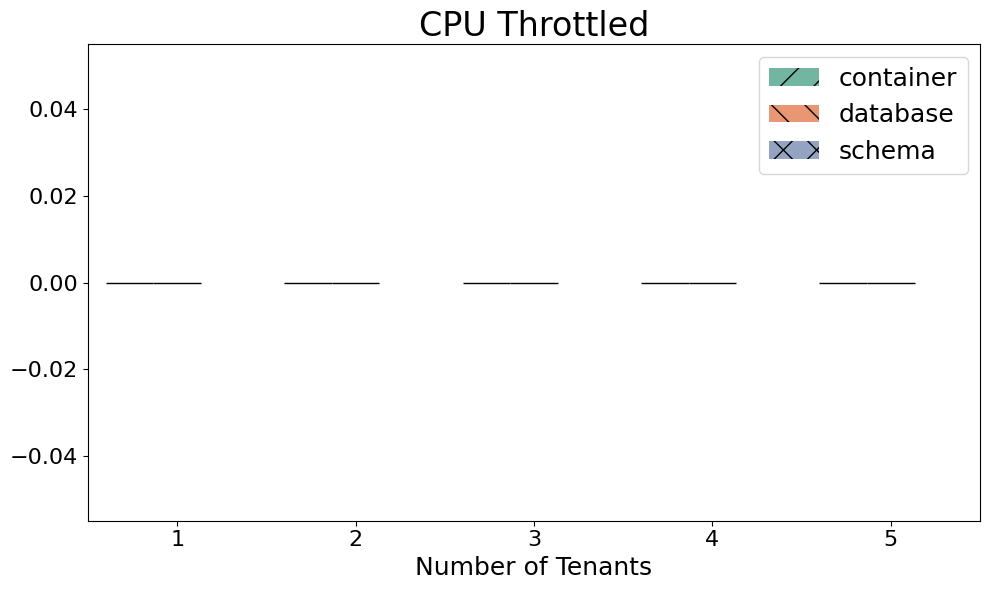

In [25]:
plot_bars(df_performance, y='CPU Throttled', title='CPU Throttled', estimator='sum')

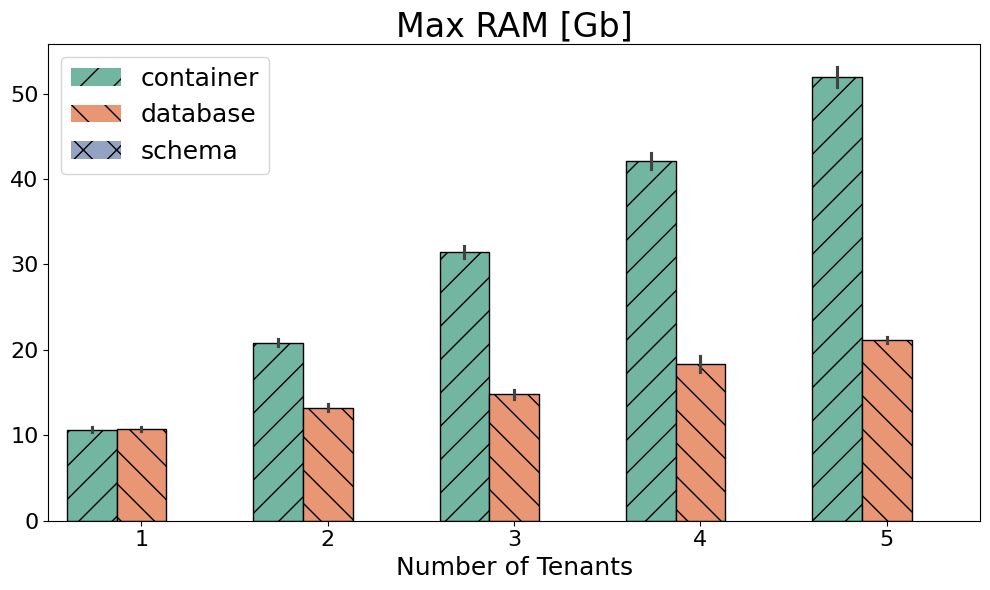

In [26]:
plot_bars(df_performance, y='Max RAM [Gb]', title='Max RAM [Gb]', estimator='sum')

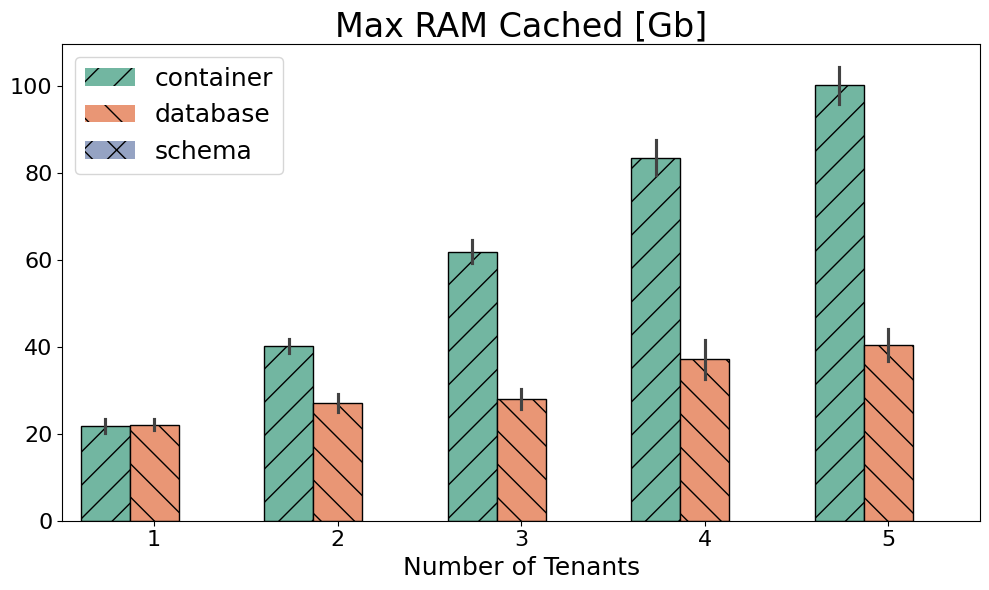

In [27]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Hardware Monitoring for Loading Phase

In [28]:
df_performance = collect.get_monitoring_all("loading")

df_performance_first = df_performance[df_performance['client']=='1']
df_performance_second = df_performance[df_performance['client']=='2']

df_performance

1753885555 None
1753888904 None
1753892425 None
1753896006 None
1753900727 None
1753883878 None
1753887176 None
1753890691 None
1753907029 None
1753898188 None


KeyError: 'num_tenants'

In [ ]:
plot_bars(df_performance, y='CPU [CPUs]', title='CPU [CPUs]', estimator='max')

In [ ]:
plot_bars(df_performance, y='Max CPU', title='Max CPU', estimator='sum')

In [ ]:
plot_bars(df_performance, y='Max RAM Cached [Gb]', title='Max RAM Cached [Gb]', estimator='sum')

# Efficiency

In [29]:
client = '1'

df_performance_monitoring = collect.get_monitoring_all(type="stream")
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = collect.get_performance_all()
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
#merged_df['I_Lat'] = 1./merged_df['E_Lat']
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']
merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,code_x,client_y,CPU [CPUs],...,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],code_y,E_Tpx,E_Lat,E_RAM
0,1,361.923330,0,267615.000000,4333843,container,1,1753885555,1,1601.43,...,0.0,0.0,0.0,0.0,NaN,0.65,1753885555,135.600056,0.048305,69.467050
1,1,402.836639,0,234512.000000,4228802,database,1,1753883878,1,2028.99,...,0.0,0.0,0.0,0.0,NaN,0.83,1753883878,119.124285,0.045843,76.730788
2,1,393.414987,0,452466.000000,7790977,container,2,1753888904,1,2027.83,...,0.0,0.0,0.0,0.0,NaN,0.87,1753888904,116.404724,0.033013,38.532320
3,1,663.769957,0,292626.000000,4945902,database,2,1753887176,1,3258.27,...,0.0,0.0,0.0,0.0,NaN,1.52,1753887176,122.231115,0.032385,103.230164
4,1,731.301607,0,392993.666667,8346748,container,3,1753892425,1,3787.28,...,0.0,0.0,0.0,0.0,NaN,1.81,1753892425,115.856489,0.025921,47.487117
5,1,559.546627,0,506087.333333,16095052,database,3,1753890691,1,2661.70,...,0.0,0.0,0.0,0.0,NaN,1.48,1753890691,126.132914,0.027246,78.367875
6,1,1105.144932,0,343995.500000,9082953,container,4,1753896006,1,5566.70,...,0.0,0.0,0.0,0.0,NaN,3.23,1753896006,119.116705,0.022852,53.647812
7,1,1131.533257,0,378372.000000,6702009,database,4,1753907029,1,5502.51,...,0.0,0.0,0.0,0.0,NaN,3.05,1753907029,123.383684,0.021916,129.614348
8,1,915.601608,0,577299.600000,24938300,container,5,1753900727,1,4869.96,...,0.0,0.0,0.0,0.0,NaN,3.19,1753900727,112.806053,0.018860,36.061505
9,1,1129.789944,0,451149.400000,6119115,database,5,1753898188,1,5347.63,...,0.0,0.0,0.0,0.0,NaN,3.04,1753898188,126.761568,0.020359,108.842962


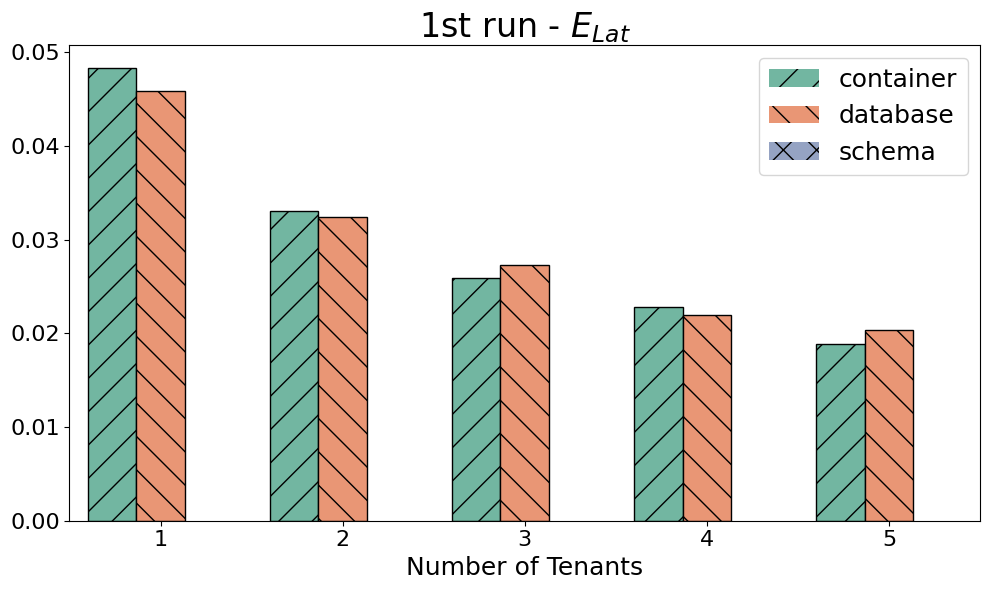

In [30]:
plot_bars(merged_df, y='E_Lat', title='1st run - $E_{Lat}$', estimator='max')

In [31]:
#plot_bars(merged_df, y='I_Lat', title='1st run - $I_{Lat}$', estimator='max')

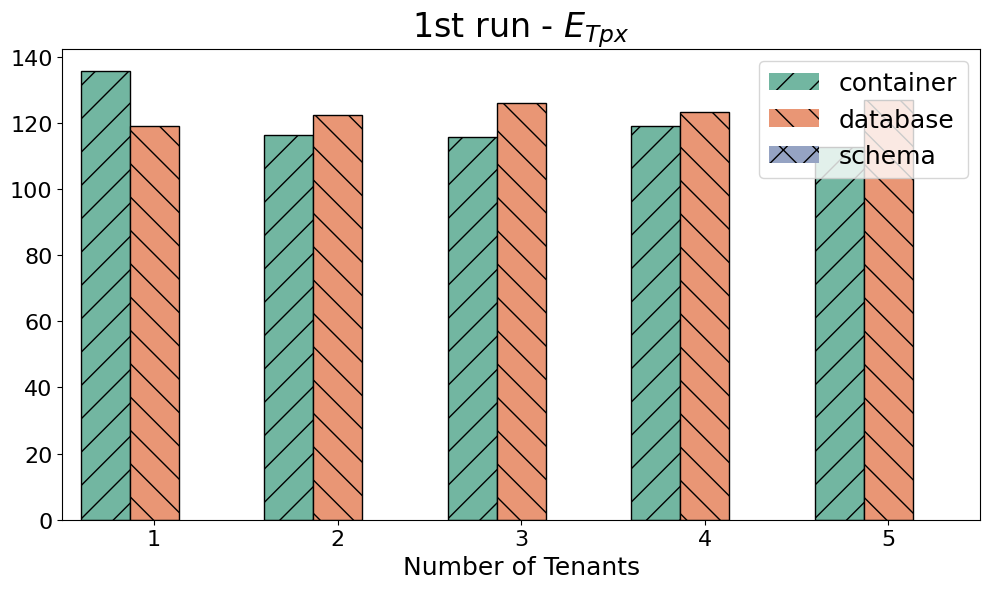

In [32]:
plot_bars(merged_df, y='E_Tpx', title='1st run - $E_{Tpx}$', estimator='max')

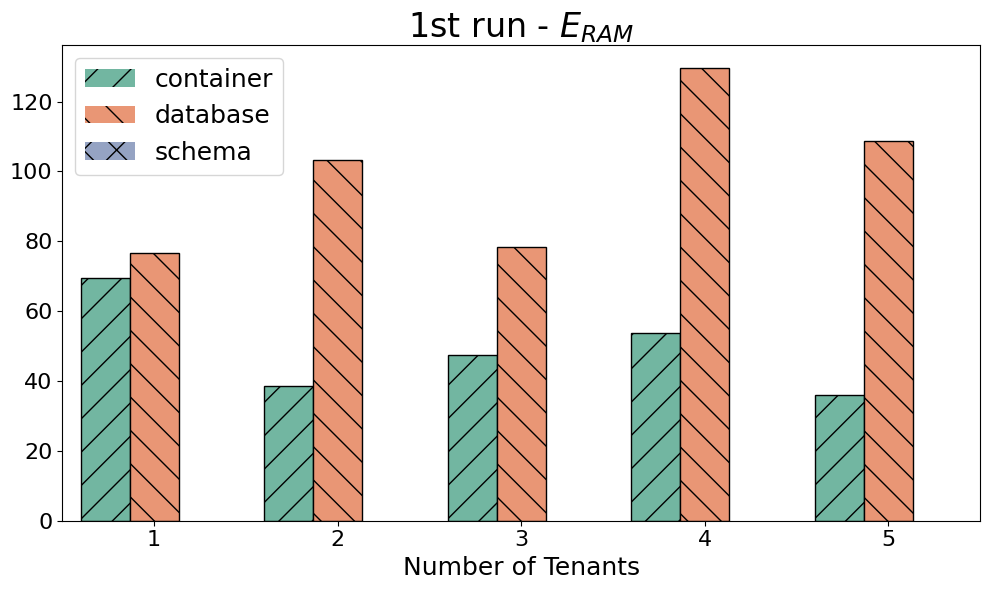

In [33]:
plot_bars(merged_df, y='E_RAM', title='1st run - $E_{RAM}$', estimator='min')

In [34]:
client = '2'

df_performance_monitoring = collect.get_monitoring_all(type="stream")
df_performance_monitoring = df_performance_monitoring[df_performance_monitoring['client'] == client]
df_performance = collect.get_performance_all()
df_performance = df_performance[df_performance['client'] == client]
merged_df = pd.merge(df_performance, df_performance_monitoring, on=['type', 'num_tenants'], how='inner')
#merged_df['CPUs/Request'] = merged_df['CPU [CPUs]'] / merged_df['Goodput (requests/second)'] / 600.
merged_df['E_Tpx'] = merged_df['Goodput (requests/second)'] / merged_df['CPU [CPUs]'] * 600.
merged_df['E_Lat'] = 1./np.sqrt(merged_df['Latency Distribution.Average Latency (microseconds)']*merged_df['CPU [CPUs]']/1E6)
merged_df['E_RAM'] = (merged_df['Goodput (requests/second)']) / merged_df['Max RAM [Gb]']

merged_df

,client_x,Goodput (requests/second),num_errors,Latency Distribution.Average Latency (microseconds),Latency Distribution.99th Percentile Latency (microseconds),type,num_tenants,code_x,client_y,CPU [CPUs],...,Sync Time,Write Time,Number Autoanalyze,Number Autovacuum,Cache Hit Ratio [%],Variance of Core Util [%],code_y,E_Tpx,E_Lat,E_RAM
0,2,361.131654,0,252857.00,3987259,container,1,1753885555,2,1804.21,...,0.0,0.0,0.0,0.0,NaN,0.75,1753885555,120.096326,0.046819,66.020412
1,2,337.151650,0,245936.00,3921908,database,1,1753883878,2,1689.83,...,0.0,0.0,0.0,0.0,NaN,0.88,1753883878,119.710853,0.049053,61.636499
2,2,417.108310,0,448908.00,6385374,container,2,1753888904,2,2082.28,...,0.0,0.0,0.0,0.0,NaN,0.84,1753888904,120.187960,0.032708,39.312753
3,2,571.094964,0,327469.00,5588638,database,2,1753887176,2,2731.34,...,0.0,0.0,0.0,0.0,NaN,1.19,1753887176,125.453799,0.033437,83.861228
4,2,777.141637,0,392865.00,5924835,container,3,1753892425,2,3994.13,...,0.0,0.0,0.0,0.0,NaN,2.04,1753892425,116.742565,0.025245,48.359778
5,2,610.344973,0,485588.00,6412815,database,3,1753890691,2,2819.27,...,0.0,0.0,0.0,0.0,NaN,1.15,1753890691,129.894258,0.027027,79.783657
6,2,957.721630,0,385210.25,5900867,container,4,1753896006,2,4875.72,...,0.0,0.0,0.0,0.0,NaN,3.19,1753896006,117.856025,0.023074,44.524483
7,2,1181.816601,0,322642.75,4889784,database,4,1753907029,2,5722.82,...,0.0,0.0,0.0,0.0,NaN,3.38,1753907029,123.905690,0.023272,122.595083
8,2,1250.098226,0,392604.80,5262270,container,5,1753900727,2,6183.93,...,0.0,0.0,0.0,0.0,NaN,4.16,1753900727,121.291628,0.020295,47.066951
9,2,1070.749932,0,474607.00,8648625,database,5,1753898188,2,5022.55,...,0.0,0.0,0.0,0.0,NaN,2.60,1753898188,127.913104,0.020482,99.512075


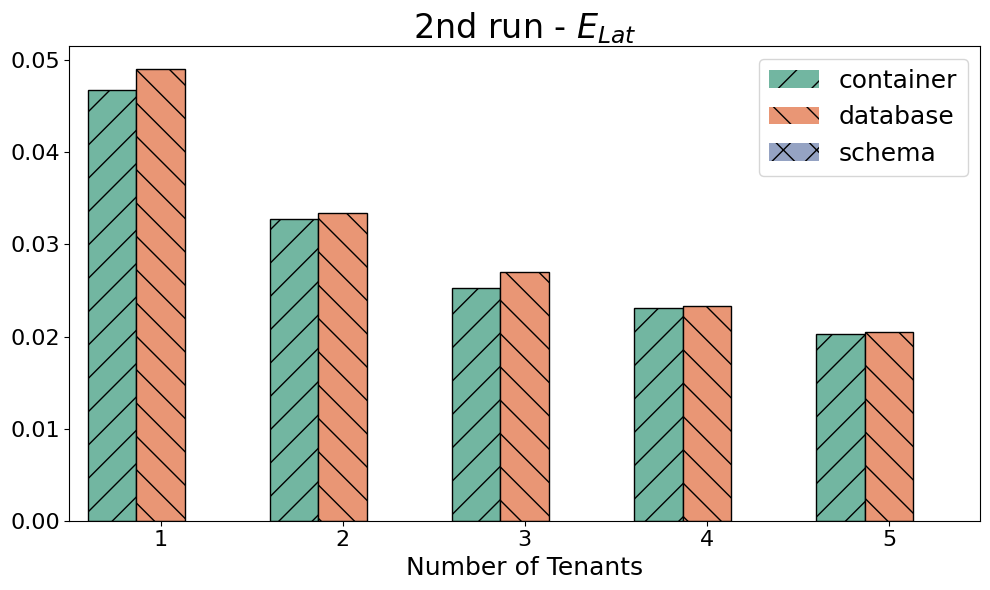

In [35]:
plot_bars(merged_df, y='E_Lat', title='2nd run - $E_{Lat}$', estimator='max')

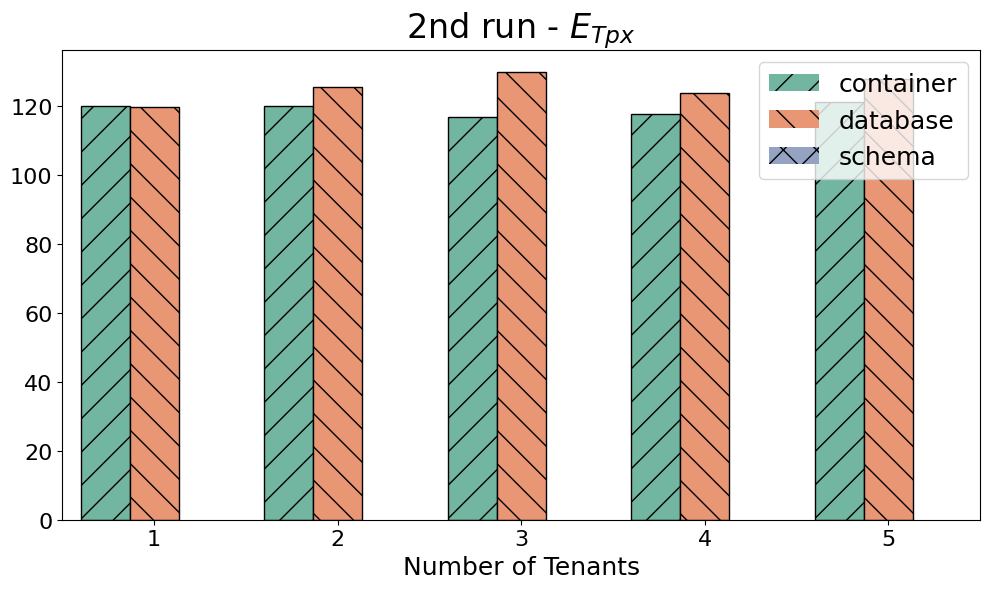

In [36]:
plot_bars(merged_df, y='E_Tpx', title='2nd run - $E_{Tpx}$', estimator='max')

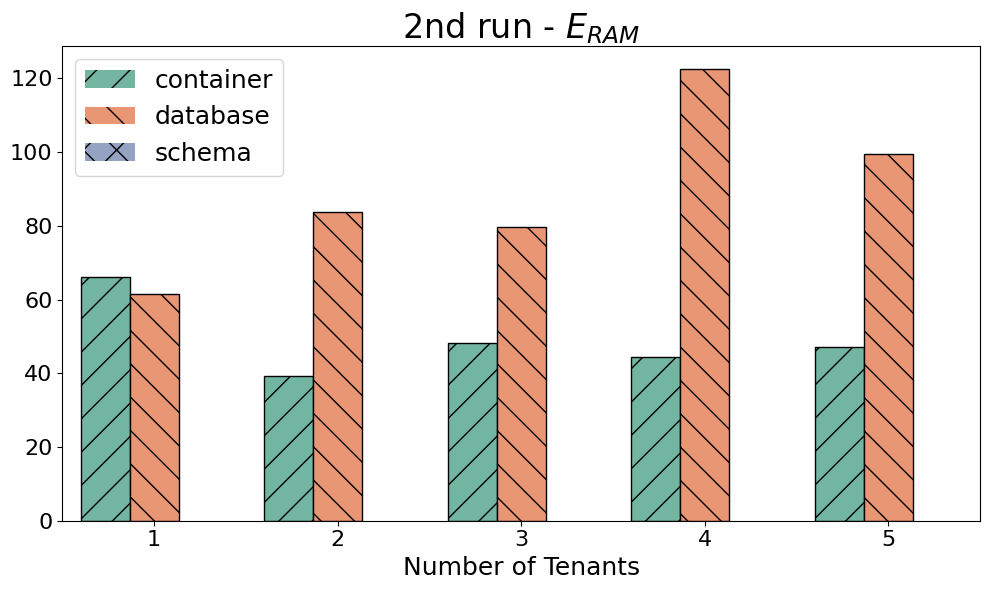

In [37]:
plot_bars(merged_df, y='E_RAM', title='2nd run - $E_{RAM}$', estimator='max')

In [ ]:
import os
import zipfile

def zip_all_results():
    # Set the base directory containing the folders
    base_dir = path # "/path/to/your/folders"  # CHANGE THIS to your actual directory
    # List all folder names in the directory
    folder_names = codes
    # Create a zip for each folder
    for folder in folder_names:
        folder_path = os.path.join(base_dir, folder)
        zip_path = os.path.join(base_dir, f"{folder}.zip")
        print(f"Zipping {folder_path} to {zip_path}...")
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    abs_path = os.path.join(root, file)
                    rel_path = os.path.relpath(abs_path, folder_path)
                    zipf.write(abs_path, arcname=os.path.join(folder, rel_path))
    print("✅ Done zipping all folders.")


In [ ]:
#zip_all_results()